<a href="https://colab.research.google.com/github/pinoke98/Artificial_Intelligence/blob/main/IA_EIA_LatLong_InformacionMapa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Localización en mapas

Captura de información para poder hacer métodos de rutas

Se debe instalar el paquete osmnx, que permite obtener mapas en un grafo con información de latitud y longitud de diferentes puntos, con sus distancias

In [ ]:
!pip install osmnx

In [ ]:
!pip install plotly_express

**Nota** : Después de instalar la biblioteca osmnx debe reiniciar el entorno de ejecuación y entonces ejecutar el siguiente código

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import numpy as np


import matplotlib.pyplot as plt
import plotly_express as px

import networkx as nx
import osmnx as ox
#ox.config(use_cache=True, log_console=True)

## Mapa de Envigado

La función **graph_from_place** recibe un texto con la dirección del lugar que se desea buscar, y tiene un parámetro *network_type* para ver cómo se desea obtener el mapa, en nuestro caso que queremos hacer ruts para trayecto en carro escogeremos: 'drive'

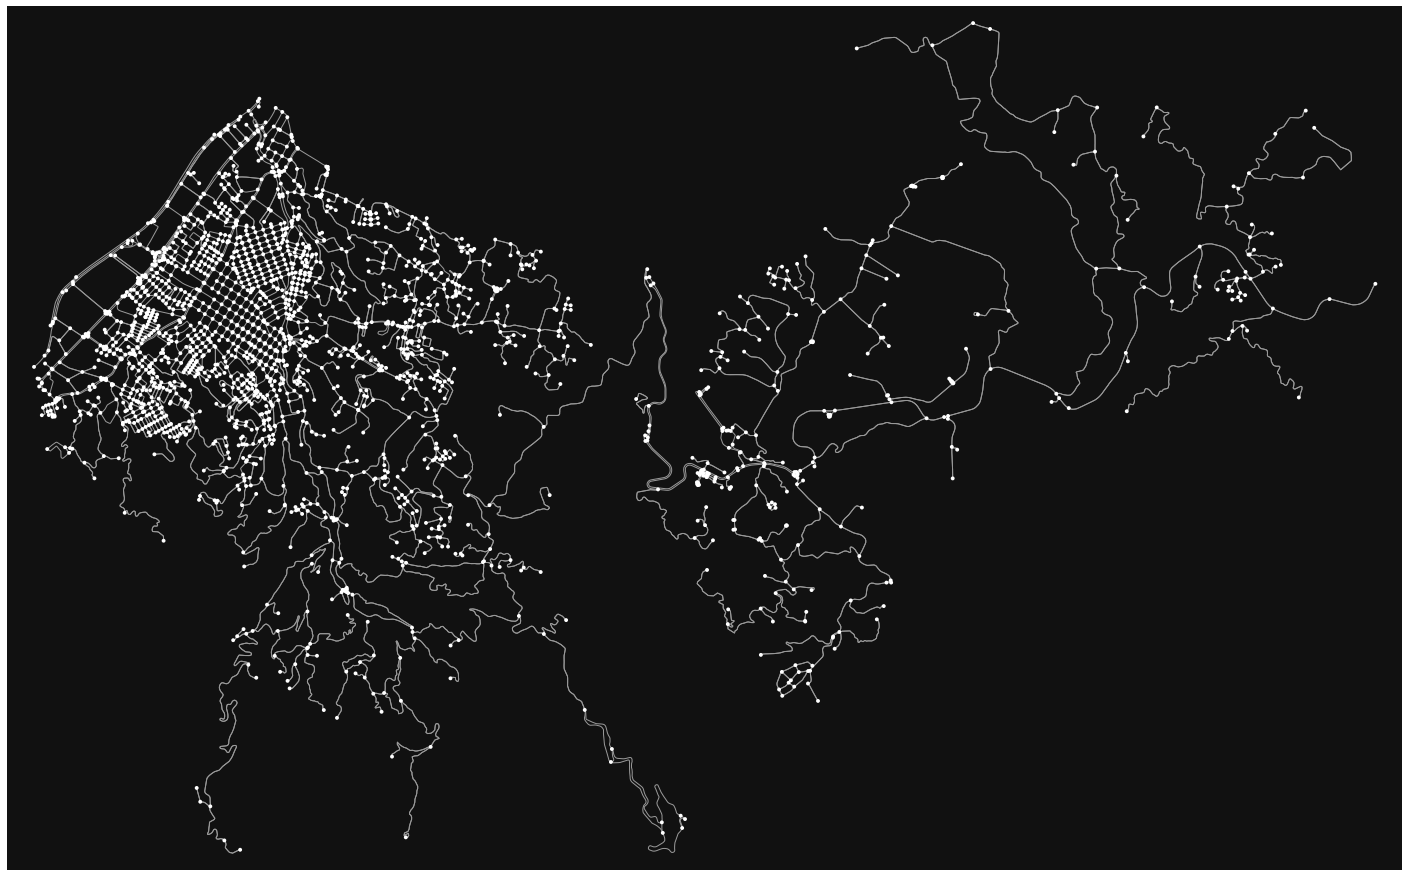

(<Figure size 1800x1800 with 1 Axes>, <AxesSubplot:>)

In [ ]:
G = ox.graph_from_place('Envigado, Antioquia, Colombia', network_type='drive',simplify=True)
ox.plot_graph(G,figsize=(25,25))

La función por defecto tiene un parámetro *simplify* puesto en True, por lo que trae un grafo simplificado, con pocos puntos. Como queremos tratar de mostrar el trayecto completo de la ruta vamos a traer más información del mapa y pondremos el parámetro en False.

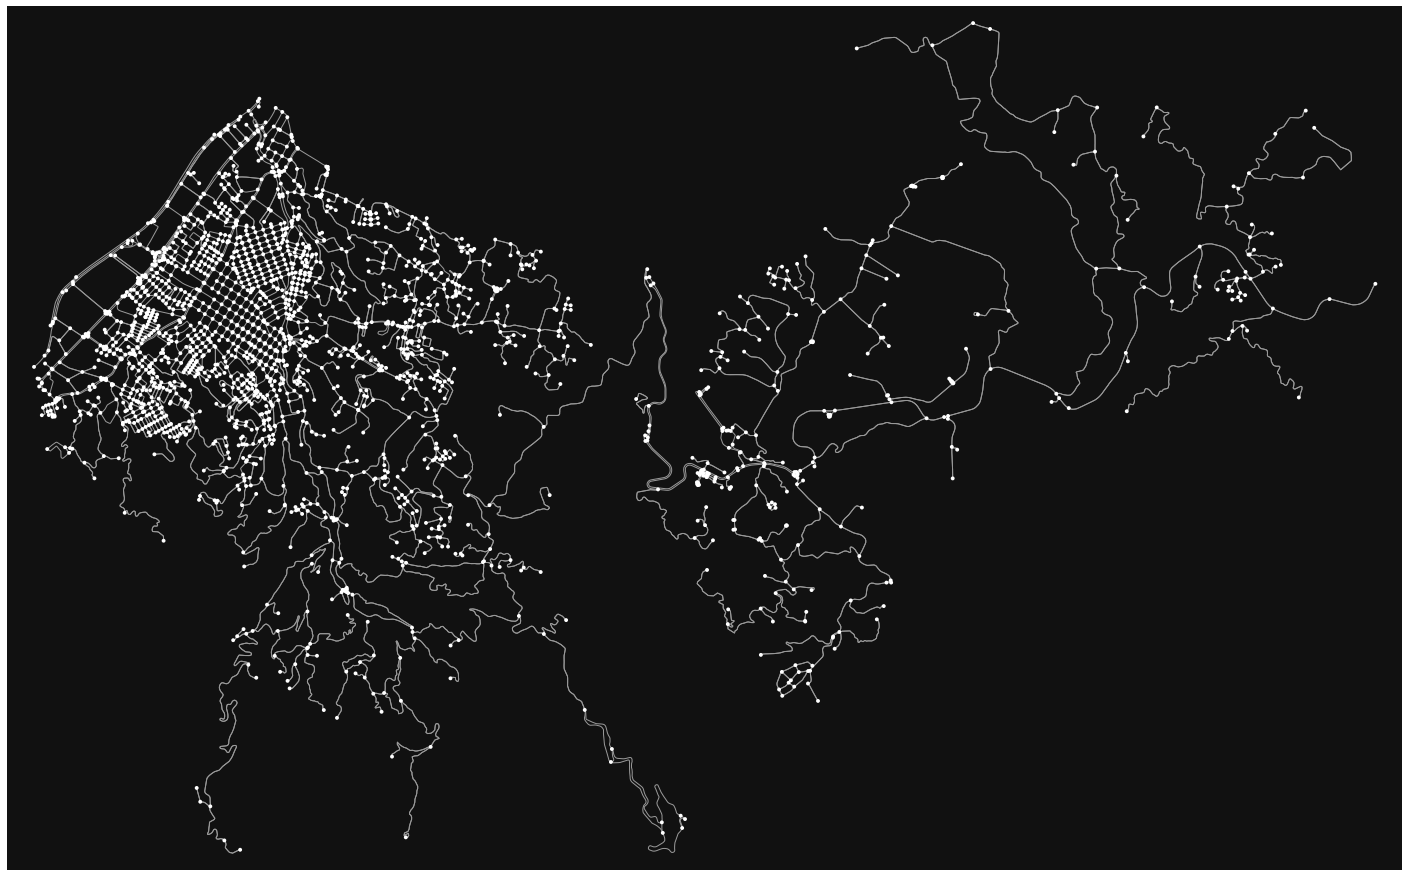

(<Figure size 1800x1800 with 1 Axes>, <AxesSubplot:>)

In [ ]:
G = ox.graph_from_place('Envigado, Antioquia, Colombia', network_type='drive',simplify=True)
ox.plot_graph(G,figsize=(25,25))

La función *graph_to_gdfs(G)* nos devuelve dos dataframe uno con los nodos y otro con las aristas del grafo.

In [ ]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [ ]:
gdf_nodes.head()

,y,x,street_count,highway,geometry
osmid,,,,,
309313461,6.159271,-75.529251,3,NaN,POINT (-75.52925 6.15927)
309313473,6.154458,-75.531317,3,NaN,POINT (-75.53132 6.15446)
309313476,6.153667,-75.532507,3,NaN,POINT (-75.53251 6.15367)
309865709,6.175071,-75.595002,3,NaN,POINT (-75.59500 6.17507)
322009433,6.185586,-75.582838,3,NaN,POINT (-75.58284 6.18559)


In [ ]:
gdf_edges.head()

osmid lanes  ... junction access
u         v          key                   ...                
309313461 5001821095 0    547527418     2  ...      NaN    NaN
          5001821054 0    547527418     2  ...      NaN    NaN
309313473 3746160666 0    547527419     2  ...      NaN    NaN
          309313476  0    910454749     2  ...      NaN    NaN
          440764629  0    913244960   NaN  ...      NaN    NaN

[5 rows x 13 columns]

Si observamos una parte del dataframe de las aristas, podemos ver que tenemos toda la información donde *u* es el nodo de partida, *v* el nodo de destino en cada uno de las conexiones de los puntos, tenemos el nombre del lugar o calle (name), el tipo de carretera (highway), la máxima velocidad en ese lugar (maxspeed), pero esta variable tiene varios nulos, para poder calcular tiempo en recurrido necesitamos llenar estos campos vacíos. 

Podemos crear una variable speed_kph que se completa con los valores maxspeed y rellena los vacíos, por defecto, la función add_edge_speeds(G) rellena los vacíos con el promedio de ese tipo de carretera, en el mapa, pero podemos también pasarle unos valores fijos, como se hizo anteriormente.

Adicionar una columna con velocidad (**speed_kph**), a partir de la maxspeed que hay

Adicionar otra columna con el tiempo de viaje (**travel_time**)

In [ ]:
#G = ox.add_edge_speeds(G)
# Para que en vez del promedio del tipo de vía, ponga uno específico como esté null
hwy_speeds = {'residential': 35,
              'secondary': 50,
              'tertiary': 60,
              'living_street':44.6,
              'primary':50.3,
              'primary_link':30,
              'secondary_link':30,
              'tertiary_link':57,
              'trunk':78,
              'trunk_link':44.6}
G = ox.add_edge_speeds(G,hwy_speeds)              
G = ox.add_edge_travel_times(G)
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [ ]:
gdf_edges.groupby('highway')[['length', 'speed_kph', 'travel_time']].mean().round(1)

TypeError: ignored

Si necesitamos buscar latitudes y longitudes de lugares específicos para buscar en un mapa podemos usar el biblioteca geopy que con Nominatim que nos permite hacerlo gratis

## Ejemplo de mostrar una ruta

In [ ]:
import geopy
from geopy.geocoders import Nominatim
locator = Nominatim(user_agent='myGeocoder')

Acá busco la longitud y latitud de la Sede de posgrados de la EIA y la sede de Palmas. Esto devuelve una variable que tiene la dirección completa y la longitud y latitud

In [ ]:
location_start = locator.geocode('Sede Posgrados EIA, Envigado, Colombia')

In [ ]:
location_end = locator.geocode('Polideportivo Sur De Envigado, Envigado, Antioquia')

In [ ]:
print(location_start.address)
print(location_end.address)

Sede Posgrados EIA, Calle 25 Sur, La Magnolia, Envigado, Valle de Aburrá, Antioquia, Región Andina, 3549090, Colombia
Polideportivo Sur, Envigado, Valle de Aburrá, Antioquia, Región Andina, Colombia


In [ ]:
print((location_start.latitude, location_start.longitude))
print((location_end.latitude, location_end.longitude))

(6.1789229, -75.57947803842347)
(6.1763773, -75.59165292605323)


Como un ejemplo de mostrar una ruta en el mapa vamos a usar la biblioteca nx con la función ***shortest_path*** que recibe un grafo de mapa, un punto de origen y uno de destino y según un peso, en este caso tiempo (por la columna *travel_time*), busca una ruta utilizando el algoritmo *dijkstra*.

Con la función ***plot_graph_route*** de ox se puede dibujar una ruta, se le debe pasar una lista de la ruta con los códigos de los nodos del grafo a dibujar en la ruta.

In [ ]:
start= (location_start.latitude, location_start.longitude)
end= (location_end.latitude, location_end.longitude)
start_node = ox.nearest_nodes(G, start[1],start[0]) 
end_node = ox.nearest_nodes(G, end[1],end[0])
route1 = nx.shortest_path(G, start_node, end_node, weight='travel_time')
print(start_node)
print(end_node)
print(route1)

5532256386
330762611
[5532256386, 340686062, 2417951901, 2946094146, 4404924432, 6133923007, 327431061, 1673517680, 1673517689, 3573194328, 1673517664, 4452257234, 3270574362, 1673517682, 3270683199, 1673517670, 327431090, 327431094, 327431097, 6927544124, 5919405598, 5919405586, 5919405587, 5919405588, 5919405589, 5919405590, 5919405591, 5919405592, 5919405593, 5919405594, 5919405607, 3501089982, 3501089965, 3501089964, 3501089962, 5497298553, 3501089957, 5497298547, 5497256273, 3501089943, 4404289842, 330762611]


In [ ]:
nextNode = gdf_edges.index
nextNode = [i for i in nextNode if i[0] == 3580856816]
nextNode

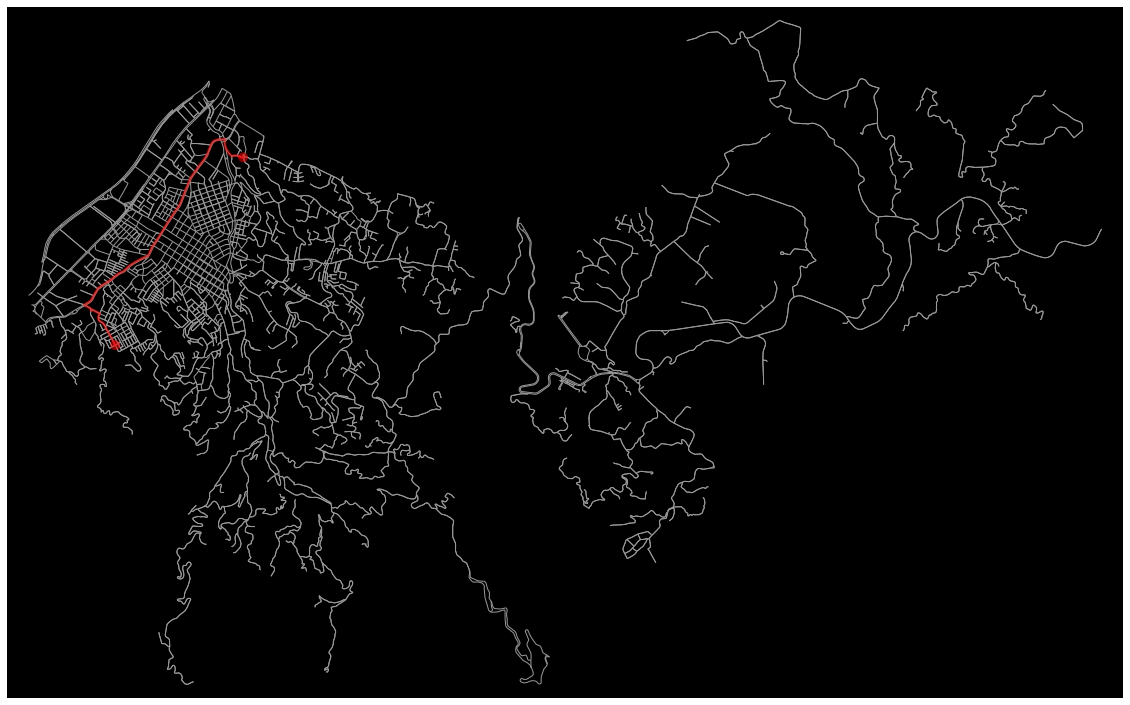

(<Figure size 1440x1440 with 1 Axes>, <AxesSubplot:>)

In [ ]:
ox.plot_graph_route(G, route1, route_linewidth=3, node_size=0, bgcolor='k',figsize=(20, 20))

Podemos hacer el mismo ejemplo buscando otra ruta pero ahora por distancia (en este caso usaríamos como peso la columna *length*)

In [ ]:
route2 = nx.shortest_path(G, start_node, end_node, weight='length')

Comparar las dos rutas

In [ ]:
route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, 'length')))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, 'length')))
route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, 'travel_time')))
route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, 'travel_time')))
print('Ruta 1 tiene', route1_length, 'metros y toma', route1_time, 'segundos.')
print('Ruta 2 tiene', route2_length, 'metros y toma', route2_time, 'segundos.')

In [ ]:
len(r)

In [ ]:
ox.plot_graph_route(G, route2, route_color='b',route_linewidth=6, node_size=0, bgcolor='k',figsize=(20, 20))

## Dataframe geográfico con información del mapa

Podemos crear nuestro propio dataframe con los datos que tenemos en el grafo

In [ ]:
node_start = []
node_end = []
X_to = []
Y_to = []
X_from = []
Y_from = []
length = []
travel_time = []

for u, v in zip(route1[:-1], route1[1:]):
    node_start.append(u)
    node_end.append(v)
    length.append(round(G.edges[(u, v, 0)]['length']))
    travel_time.append(round(G.edges[(u, v, 0)]['travel_time']))
    X_from.append(G.nodes[u]['x'])
    Y_from.append(G.nodes[u]['y'])
    X_to.append(G.nodes[v]['x'])
    Y_to.append(G.nodes[v]['y'])

In [ ]:
df = pd.DataFrame(list(zip(node_start, node_end, X_from, Y_from,  X_to, Y_to, length, travel_time)), 
               columns =["node_start", "node_end", "X_from", "Y_from",  "X_to", "Y_to", "length", "travel_time"]) 
df.head()

In [ ]:
df.reset_index(inplace=True)
df.head()

Crear un dataframe geográfico a partir de este para poder tener las longitudes y latitudes comp puntos geométricos

In [ ]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X_from, df.Y_from))
gdf["geometry_to"] = [Point(xy) for xy in zip(gdf.X_to, gdf.Y_to)]
gdf['line'] = gdf.apply(lambda row: LineString([row['geometry_to'], row['geometry']]), axis=1)
line_gdf = gdf[["node_start","node_end","length","travel_time", "line"]].set_geometry('line')

In [ ]:
df.tail()

In [ ]:
start = df[df["node_start"] == start_node]
end = df[df["node_end"] == end_node]

In [ ]:
start

In [ ]:
end

## Diferentes formas de visualización en otros mapas

In [ ]:
px.scatter_mapbox(df, lon= "X_from", lat="Y_from", zoom=12)

In [ ]:
fig = px.scatter_mapbox(df, lon= "X_from", lat="Y_from", width=800, height=400, zoom=12)
fig.add_trace(px.line_mapbox(df, lon= "X_from", lat="Y_from").data[0])

Mapbox requiere access token para algunas visualizaciones como:

'basic', 'streets', 'outdoors', 'light', 'dark', 'satellite', 'satellite- streets'

Sin embargo hay otros mapbox_style que no requieren access token como:

'open-street-map', 'white-bg', 'carto-positron', 'carto-darkmatter', 'stamen- terrain', 'stamen-toner', 'stamen-watercolor'

In [ ]:
fig = px.scatter_mapbox(df, lon= "X_from", lat="Y_from", zoom=12, width=1000, height=600, animation_frame="index",mapbox_style='open-street-map')
fig.data[0].marker = dict(size = 12, color="black")
fig.add_trace(px.scatter_mapbox(start, lon= "X_from", lat="Y_from").data[0])
fig.data[1].marker = dict(size = 15, color="red")
fig.add_trace(px.scatter_mapbox(end, lon= "X_from", lat="Y_from").data[0])
fig.data[2].marker = dict(size = 15, color="green")
fig.add_trace(px.line_mapbox(df, lon= "X_from", lat="Y_from").data[0])
fig

In [ ]:
#graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2) 
route_graph_map = ox.plot_route_folium(G, route,popup_attribute='name', edge_width=2) 
route_graph_map.save('route.html')

In [ ]:
display(route_graph_map)